In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

retail = pd.read_csv('../../[DATASET C] Retail Supply Chain Sales Analysis/processed/retail_cleaned.csv')
calendar = pd.read_csv('../../[DATASET C] Retail Supply Chain Sales Analysis/processed/calendar_cleaned.csv')

retail['order_date'] = pd.to_datetime(retail['order_date'])
retail['ship_date'] = pd.to_datetime(retail['ship_date'])
calendar['date'] = pd.to_datetime(calendar['date'])

## Split into 3 sets: train, validation, test

Because the dataset has a strong geographical distribution bias, a random split would be unfair. Therefore, I use stratified sampling to divide the dataset into three sets while preserving the same distribution.

In [2]:
# We need to track sales across all regions over time, and since sales is a crucial variable in the dataset, we apply binning to prevent bias during dataset splitting, especially because the values are continuous

retail['sales_cat'] = pd.qcut(retail['sales'], q=10, labels=False) 
retail['stratify_key'] = retail['region'].astype(str) + "_" + retail['sales_cat'].astype(str)

split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, temp_index in split1.split(retail, retail['stratify_key']):
    train_set = retail.loc[train_index]
    temp_set = retail.loc[temp_index]

split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for val_index, test_index in split2.split(temp_set, temp_set['stratify_key']):
    val_set = temp_set.iloc[val_index]
    test_set = temp_set.iloc[test_index]

for set_ in (train_set, val_set, test_set):
    set_.drop(['sales_cat', 'stratify_key'], axis=1, inplace=True)

print(f"Kích thước: Train={len(train_set)}, Val={len(val_set)}, Test={len(test_set)}")

Kích thước: Train=7995, Val=999, Test=1000


C:\Users\chanc\AppData\Local\Temp\ipykernel_46948\729923570.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop(['sales_cat', 'stratify_key'], axis=1, inplace=True)
C:\Users\chanc\AppData\Local\Temp\ipykernel_46948\729923570.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop(['sales_cat', 'stratify_key'], axis=1, inplace=True)


### Check the sales distribution between 3 sets

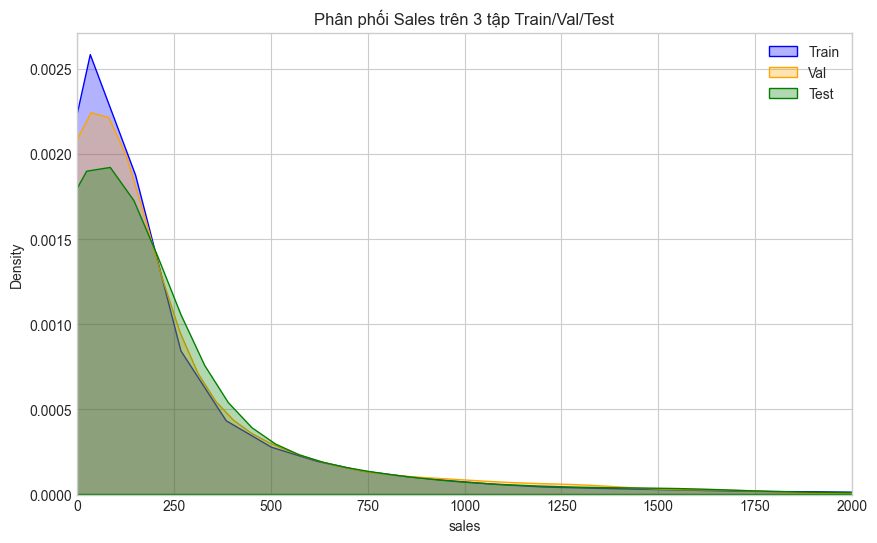

In [3]:
plt.figure(figsize=(10, 6))
sns.kdeplot(train_set['sales'], label='Train', color='blue', fill=True, alpha=0.3)
sns.kdeplot(val_set['sales'], label='Val', color='orange', fill=True, alpha=0.3)
sns.kdeplot(test_set['sales'], label='Test', color='green', fill=True, alpha=0.3)
plt.title('Phân phối Sales trên 3 tập Train/Val/Test')
plt.xlim(0, 2000)
plt.legend()
plt.show()

Cả 3 tập đều tuân theo cùng một quy luật phân phối, không có hiện tượng tập này lệch hẳn so với tập kia.

### Statistic testing (Kolmogorov-Smirnov Test)


In [4]:
from scipy.stats import ks_2samp

metric_cols = ['sales', 'profit', 'quantity', 'discount']

print(f"{'FEATURE':<15} | {'P-VALUE (Test)':<15} | {'P-VALUE (Val)':<15} | {'KẾT LUẬN'}")
print("-" * 65)

for col in metric_cols:
    # Kiểm tra Train vs Test
    stat_test, p_value_test = ks_2samp(train_set[col], test_set[col])
    
    # Kiểm tra Train vs Val
    stat_val, p_value_val = ks_2samp(train_set[col], val_set[col])
    
    # Đánh giá (Ngưỡng 0.05)
    # Nếu p > 0.05: Không đủ bằng chứng để bác bỏ H0 -> Phân phối giống nhau (Tốt)
    # Nếu p < 0.05: Phân phối khác nhau (Cảnh báo)
    is_good = (p_value_test > 0.05) and (p_value_val > 0.05)
    verdict = "✅ OK" if is_good else "⚠️ LỆCH"
    
    print(f"{col:<15} | {p_value_test:.4f}{' '*10} | {p_value_val:.4f}{' '*10} | {verdict}")

FEATURE         | P-VALUE (Test)  | P-VALUE (Val)   | KẾT LUẬN
-----------------------------------------------------------------
sales           | 0.9995           | 0.9992           | ✅ OK
profit          | 0.2107           | 0.6513           | ✅ OK
quantity        | 0.6741           | 0.5474           | ✅ OK
discount        | 0.9960           | 0.3739           | ✅ OK


Overall, splitting the dataset into three subsets is acceptable, as the distribution of the `sales` field is balanced across all three.

In [5]:
train_set.to_csv('../../[DATASET C] Retail Supply Chain Sales Analysis/processed/splitting/train_set.csv', index=False)
val_set.to_csv('../../[DATASET C] Retail Supply Chain Sales Analysis/processed/splitting/val_set.csv', index=False)
test_set.to_csv('../../[DATASET C] Retail Supply Chain Sales Analysis/processed/splitting/test_set.csv', index=False)

## EDA

 EDA in train set

#### Với các giá trị số

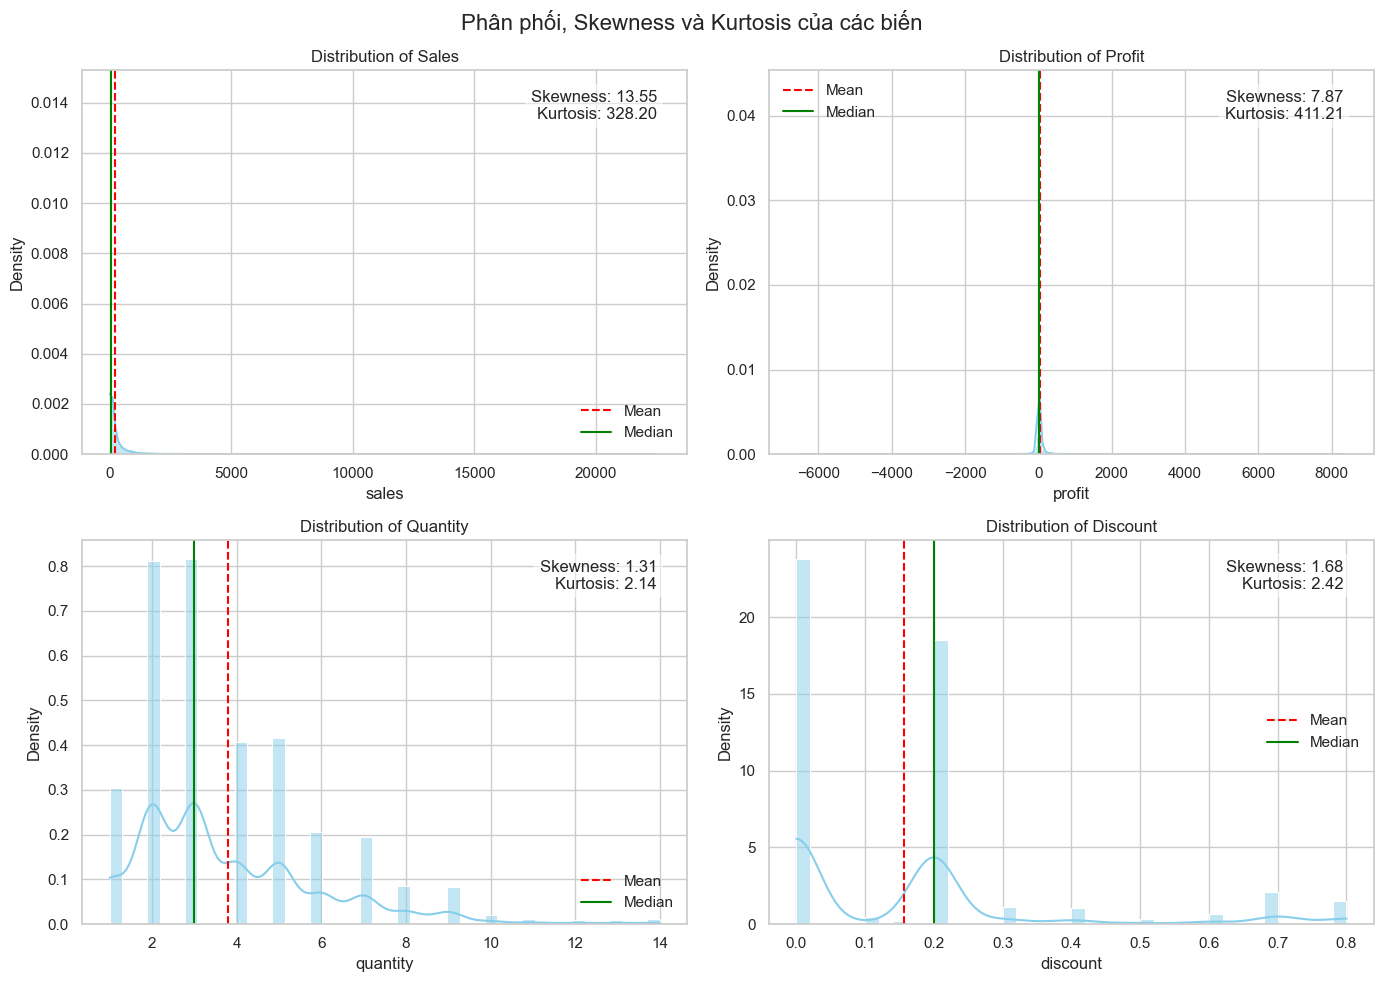

In [ ]:

features = ['sales', 'profit', 'quantity', 'discount']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Phân phối, Skewness và Kurtosis của các biến', fontsize=16)

axes = axes.flatten()

for i, col in enumerate(features):
    ax = axes[i]
    
    skew_val = train_set[col].skew()
    kurt_val = train_set[col].kurt()
    
    sns.histplot(train_set[col], kde=True, ax=ax, color='skyblue', stat='density')
    
    ax.axvline(train_set[col].mean(), color='red', linestyle='--', label='Mean')
    ax.axvline(train_set[col].median(), color='green', linestyle='-', label='Median')
    
    text_str = f'Skewness: {skew_val:.2f}\nKurtosis: {kurt_val:.2f}'
    ax.text(0.95, 0.95, text_str, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    ax.set_title(f'Distribution of {col.capitalize()}')
    ax.legend()

plt.tight_layout()
plt.show()

* `sales` và `profit`: phân phối rất lệch phải và cực nhọn, nhiều outlier lớn.
→ Cần log-transform hoặc clipping trước khi dùng cho mô hình học máy hoặc thống kê chuẩn.

* `quantity` và `discount`: phân phối nhẹ lệch phải, tương đối bình thường, không quá nghiêm trọng, có thể dùng trực tiếp.

#### Với các giá trị danh mục

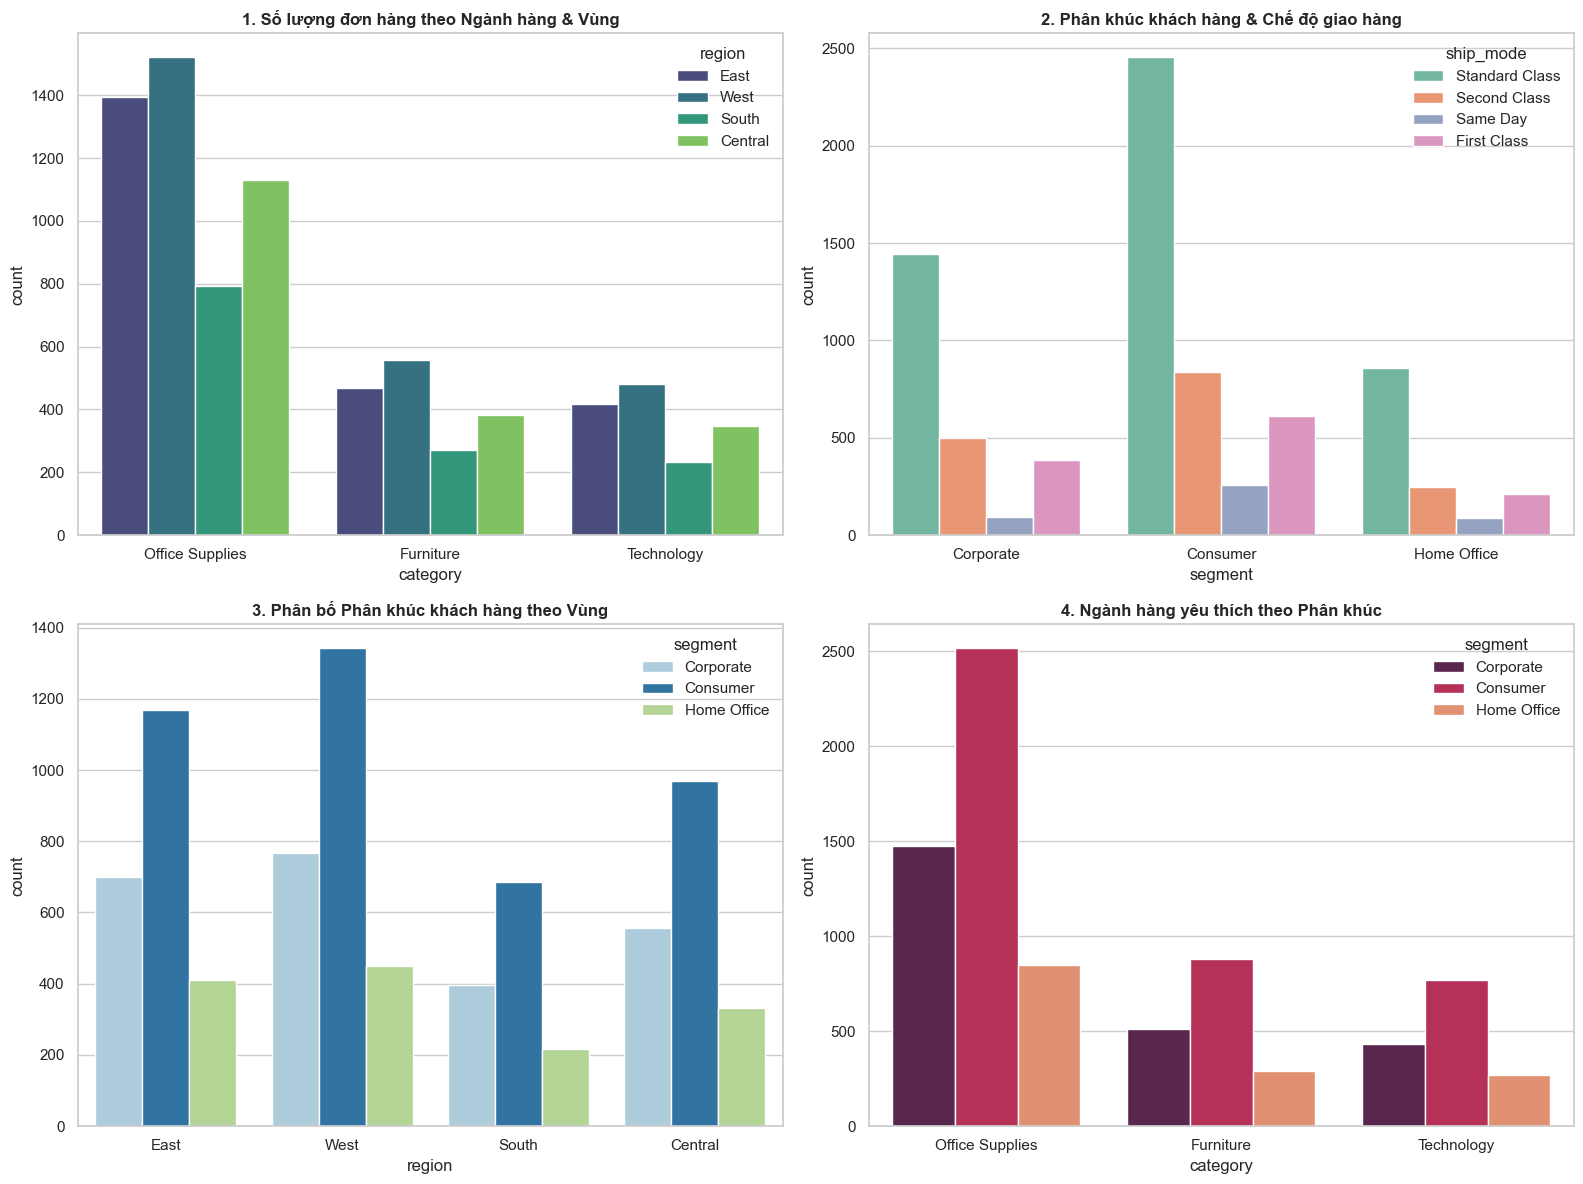

In [9]:
# 1. Xác định các cột danh mục quan trọng (ít giá trị duy nhất)
# Không chọn City, State hay Product Name vì quá nhiều giá trị
cat_cols = ['category', 'segment', 'region', 'ship_mode']

# 2. Thiết lập lưới biểu đồ (Grid)
# Chúng ta sẽ vẽ 4 biểu đồ tiêu biểu
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
sns.set_style("whitegrid")

# --- Biểu đồ 1: Số lượng đơn hàng theo Ngành hàng (Category) - Phân theo Vùng (Region) ---
# Insight: Xem vùng nào thích mua đồ Công nghệ hay Nội thất hơn
sns.countplot(data=train_set, x='category', hue='region', ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('1. Số lượng đơn hàng theo Ngành hàng & Vùng', fontsize=12, fontweight='bold')
axes[0, 0].legend(title='region', loc='upper right')

# --- Biểu đồ 2: Phân khúc khách hàng (Segment) - Phân theo Chế độ giao hàng (Ship Mode) ---
# Insight: Khách Doanh nghiệp (Corporate) hay Khách lẻ (Consumer) chịu chi cho ship nhanh?
sns.countplot(data=train_set, x='segment', hue='ship_mode', ax=axes[0, 1], palette='Set2')
axes[0, 1].set_title('2. Phân khúc khách hàng & Chế độ giao hàng', fontsize=12, fontweight='bold')
axes[0, 1].legend(title='ship_mode')

# --- Biểu đồ 3: Vùng (Region) - Phân theo Phân khúc (Segment) ---
# Insight: Cơ cấu khách hàng ở mỗi vùng miền có khác nhau không?
sns.countplot(data=train_set, x='region', hue='segment', ax=axes[1, 0], palette='Paired')
axes[1, 0].set_title('3. Phân bố Phân khúc khách hàng theo Vùng', fontsize=12, fontweight='bold')

# --- Biểu đồ 4: Ngành hàng (Category) - Phân theo Phân khúc (Segment) ---
# Insight: Nhóm khách nào mua nhiều đồ nội thất nhất?
sns.countplot(data=train_set, x='category', hue='segment', ax=axes[1, 1], palette='rocket')
axes[1, 1].set_title('4. Ngành hàng yêu thích theo Phân khúc', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


1. Biểu đồ 1: Số lượng đơn hàng theo Ngành hàng & Vùng (Category vs. Region)
* Insight:

    * Thống trị tuyệt đối của "Office Supplies": Ở bất kỳ vùng nào (West, East, Central, South), đồ dùng văn phòng (Office Supplies) luôn chiếm số lượng đơn hàng áp đảo (cao gấp 2-3 lần Furniture và Technology).

    * Miền Tây (West - Cột xanh đậm thứ 2) là thị trường lớn nhất: Số lượng đơn hàng ở miền Tây cao nhất ở cả 3 ngành hàng. Điều này khớp với biểu đồ Bubble Chart trước đó (West có ROI và Sales tốt).

    * Miền Nam (South - Cột xanh lá đậm) yếu thế: Luôn là vùng có lượng đơn thấp nhất.

* Hành động: Khi chạy Clustering, biến Region có thể không phân tách nhóm quá mạnh vì xu hướng tiêu dùng (thích Office Supplies) là giống hệt nhau giữa các vùng. Sự khác biệt chỉ nằm ở quy mô (Volume).

2. Biểu đồ 2: Phân khúc & Chế độ giao hàng (Segment vs. Ship Mode)
* Insight:
    * "Standard Class" là vua: Mọi phân khúc khách hàng đều chọn giao hàng tiêu chuẩn (Standard Class).
    * Tiềm năng từ "First Class" (Giao hạng nhất - Cột hồng): Hãy chú ý cột màu hồng. Ở nhóm Consumer, khách hàng chọn First Class nhiều hơn hẳn so với Same Day (Cột tím nhạt). Điều này cho thấy khách lẻ sẵn sàng trả tiền để nhận nhanh (nhưng không cần gấp trong ngày).

    * Khách doanh nghiệp (Corporate) ít dùng Same Day: Cột tím nhạt ở nhóm Corporate rất thấp. Doanh nghiệp thường lên kế hoạch trước nên ít khi cần giao gấp trong ngày.

* Hành động: Có thể tạo feature Ship_Speed_Preference (Sở thích giao hàng) cho Clustering. Nhóm khách hay dùng "First Class" hoặc "Same Day" có thể là nhóm khách VIP cần chăm sóc kỹ.

3. Biểu đồ 3: Phân bố Phân khúc khách hàng theo Vùng
* Insight:

    * Cấu trúc khách hàng "bất biến": Dù ở vùng nào, tỷ lệ luôn là: Consumer > Corporate > Home Office. Không có vùng nào đặc thù kiểu "chuyên khách doanh nghiệp".

    * Sự đồng nhất này là tốt cho Model: Nó chứng tỏ tập dữ liệu Train của bạn được lấy mẫu rất tốt, không bị thiên lệch (Bias) về một vùng cụ thể nào.

4. Biểu đồ 4: Ngành hàng yêu thích theo Phân khúc
* Insight:
    * Consumer (Màu đỏ) là người mua nội thất chính: Cột Furniture màu đỏ cao vượt trội so với 2 phân khúc kia.
    * Corporate (Màu tím) mua Technology khá nhiều: Tỷ lệ mua Technology của khách Corporate khá tốt so với mua Furniture.

**Kết luận quan trọng**:

* Nhóm Consumer: Mua lặt vặt (Office Supplies) và mua Nội thất (thường ship nặng, dễ hoàn trả). -> Rủi ro cao hơn.

* Nhóm Corporate: Mua lặt vặt và đồ Công nghệ (Giá trị cao, ship nhẹ). -> Biên lợi nhuận tiềm năng tốt hơn.

**TỔNG KẾT CHIẾN LƯỢC TỪ BIỂU ĐỒ**:
Dữ liệu cho thấy hành vi mua sắm (mua cái gì, ở đâu) khá tương đồng giữa các nhóm. Sự khác biệt lớn nhất nằm ở SỐ LƯỢNG (Volume) và LOẠI HÀNG (High Value vs Low Value).

Điều này cho thấy: 
* Phải dùng RFM (Recency, Frequency, Monetary): Vì sự khác biệt nằm ở tần suất mua và số tiền mua, chứ không phải ở việc họ ở vùng nào.
* Kết hợp Return Rate: Vì nhóm Consumer mua nhiều Furniture (dễ bị trả lại), nên cần lọc kỹ nhóm này.

### Analysis problems

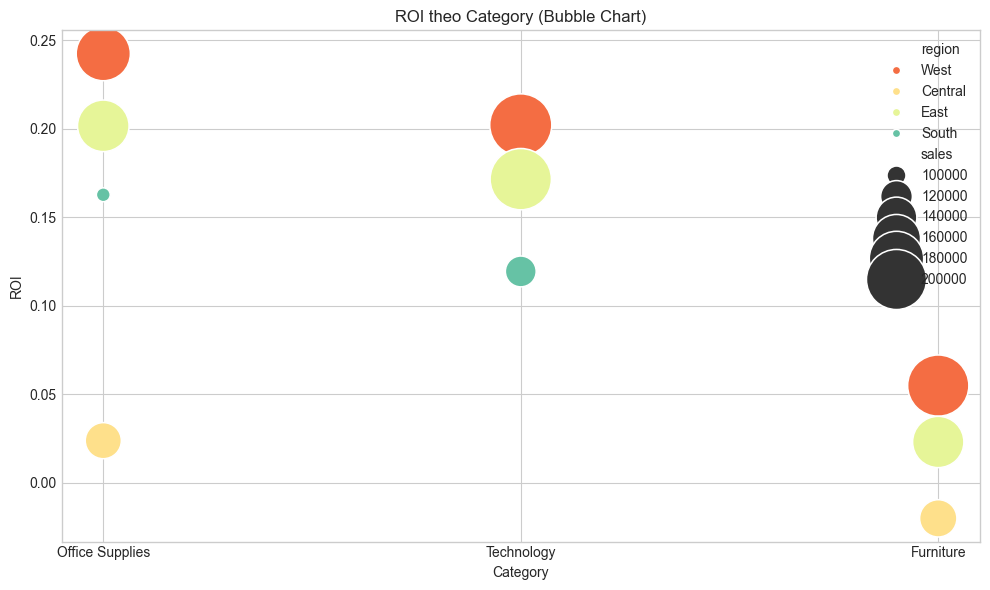

In [ ]:
# ROI per category & region (after returns)
roi_performance = (
    train_set
        .groupby(['category', 'region'], as_index=False)
        .agg(profit=('profit', 'sum'),
             sales=('sales', 'sum'))
)

# Tránh chia cho 0
roi_performance['ROI'] = roi_performance.apply(
    lambda row: row['profit'] / row['sales'] if row['sales'] != 0 else 0, axis=1
)

# Sắp xếp để biểu đồ rõ ràng hơn
roi_performance = roi_performance.sort_values(by='ROI', ascending=False)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=roi_performance,
    x='category',
    y='ROI',
    size='sales',
    hue='region',
    sizes=(100, 2000),
    palette='Spectral'
)
plt.title('ROI theo Category (Bubble Chart)')
plt.xlabel('Category')
plt.ylabel('ROI')
plt.tight_layout()
plt.show()




1. "West" (Màu Cam) là "Ngôi sao sáng" - Hiệu suất vượt trội
* Quan sát: Ở cả 3 ngành hàng (Office Supplies, Technology, Furniture), các bong bóng màu Cam (West Region) luôn nằm ở vị trí cao nhất trên trục Y (ROI).

* Insight: Khu vực miền Tây (West) không chỉ bán tốt (bong bóng to) mà còn quản lý chi phí cực tốt (ROI cao nhất, đạt đỉnh ~25% ở Office Supplies).

* Hành động: Cần xem quy trình vận hành, chính sách giá hoặc shipping của vùng West để "copy" mô hình này áp dụng sang các vùng khác.

2. "Furniture" (Đồ nội thất) là "Gánh nặng" của cả công ty
* Quan sát: Toàn bộ cột Furniture nằm tụt hẳn xuống phía dưới trục Y so với 2 ngành hàng kia. ROI cao nhất của ngành này (West) cũng chỉ khoảng 5%, trong khi ngành khác là 20-25%.

* Cảnh báo đỏ: Có một bong bóng màu Vàng (Central Region) nằm dưới mức 0 (ROI âm).

* Insight: Kinh doanh nội thất ở miền Trung (Central) đang LỖ VỐN. Bán càng nhiều càng lỗ (vì bong bóng này kích thước không hề nhỏ). Nguyên nhân khả nghi nhất là Chi phí vận chuyển (Shipping Cost) quá cao cho hàng cồng kềnh hoặc tỷ lệ hàng bị trả lại/hư hỏng cao.

3. Nghịch lý "Office Supplies" tại miền Trung (Central - Màu vàng)
* Quan sát: Hãy nhìn vào cột Office Supplies. Bong bóng màu Vàng (Central) có kích thước khá lớn (Doanh số Sales cao, có thể ngang ngửa West). Tuy nhiên, vị trí của nó lại nằm sát đáy (ROI ~2-3%).

* Insight: Miền Trung đang "bán lấy số lượng" (Volume game) nhưng lợi nhuận ròng cực mỏng. Giả thuyết: Có thể nhân viên kinh doanh ở đây đang lạm dụng Discount (giảm giá) để đẩy doanh số, hoặc chi phí hoạt động ở đây đang có vấn đề bất thường. Đây là điểm cần kiểm tra ngay trong tập Train.

4. Technology là "Con gà đẻ trứng vàng" ổn định nhất
* Quan sát: Các bong bóng ở cột Technology phân bố khá tập trung ở vùng ROI cao (từ 12% - 20%). Không có vùng nào bị tụt hậu quá sâu.
* Insight: Đây là danh mục an toàn nhất và hiệu quả nhất để đầu tư marketing thêm, vì rủi ro thấp và biên lợi nhuận đều đặn giữa các vùng miền.

           Recency   Frequency         sales       profit    discount  \
count   790.000000  790.000000    790.000000   790.000000  790.000000   
mean    180.884810    5.627848   2339.478498   296.353868    0.157240   
std     203.070469    2.360583   2344.547705   819.142033    0.094548   
min       0.000000    1.000000      4.419000 -6632.167500    0.000000   
25%      41.000000    4.000000    859.694500    30.520825    0.085877   
50%     105.500000    5.000000   1695.879000   184.561150    0.150000   
75%     257.000000    7.000000   2907.637250   449.708875    0.212500   
max    1191.000000   15.000000  25035.082000  8665.849000    0.700000   

       Return_Rate  
count   790.000000  
mean      0.063635  
std       0.122778  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.125000  
max       1.000000  


C:\Users\chanc\AppData\Local\Temp\ipykernel_28152\3510380333.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return_stats = df.groupby('customer_id').apply(


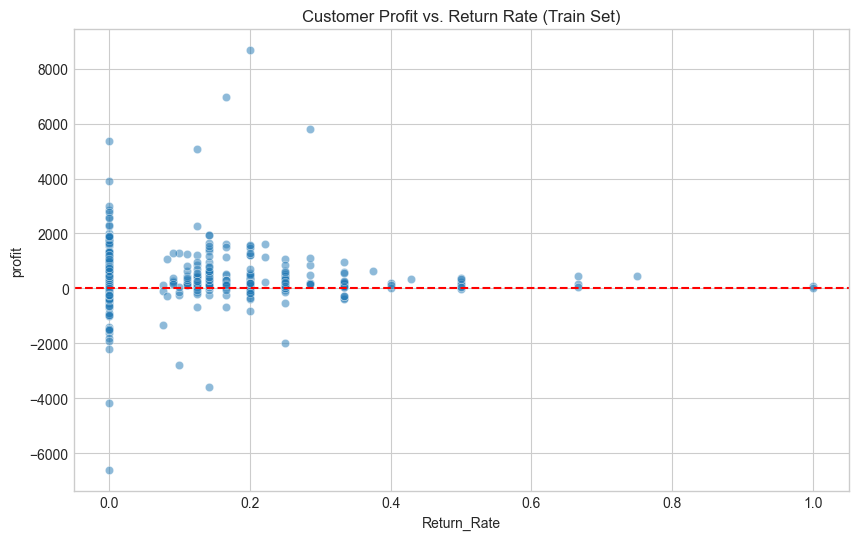

In [ ]:
def generate_customer_features(df):

    # 1. Tổng hợp cơ bản (RFM + Profit)
    customer_group = df.groupby('customer_id').agg({
        'order_date': lambda x: (df['order_date'].max() - x.max()).days, # Recency
        'order_id': 'nunique', # Frequency
        'sales': 'sum',        # Monetary
        'profit': 'sum',       # Profitability
        'discount': 'mean'     # Avg Discount Preference
    }).rename(columns={'order_date': 'Recency', 'order_id': 'Frequency'})
    
    # 2. Tính tỷ lệ trả hàng (Return Rate) cho từng khách
    # Tính tổng đơn hàng và số đơn bị trả
    return_stats = df.groupby('customer_id').apply(
        lambda x: pd.Series({
            'Total_Orders': x['order_id'].nunique(),
            'Returned_Orders': x[x['returned'] == 'Yes']['order_id'].nunique()
        })
    )
    # Tính tỷ lệ
    return_stats['Return_Rate'] = return_stats['Returned_Orders'] / return_stats['Total_Orders']
    
    # 3. Merge lại
    final_features = customer_group.merge(return_stats[['Return_Rate']], on='customer_id')
    
    return final_features

# Áp dụng
train_features = generate_customer_features(train_set)

# EDA trên features mới tạo
print(train_features.describe())

# Xem thử quan hệ giữa Lợi nhuận và Tỷ lệ trả hàng
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_features, x='Return_Rate', y='profit', alpha=0.5)
plt.title('Customer Profit vs. Return Rate (Train Set)')
plt.axhline(0, color='red', linestyle='--')
plt.show()

1. Insight "Nghịch lý": Khách hàng gây lỗ nặng nhất lại là người... không bao giờ trả hàng!
Quan sát: Hãy nhìn vào góc dưới cùng bên trái (Return Rate = 0.0). Có một điểm dữ liệu (khách hàng) đang gây lỗ khủng khiếp (~ -6500 Profit) và một nhóm các điểm gây lỗ từ -2000 đến -4000.

* Ý nghĩa: Chúng ta thường nghĩ "Trả hàng làm mất lợi nhuận", nhưng biểu đồ này chứng minh ngược lại. Những khoản lỗ lớn nhất đến từ những đơn hàng thành công (không bị trả).

* Nguyên nhân dự đoán:

    * Khách hàng này mua các sản phẩm `Furniture` (cồng kềnh, ship đắt) với biên lợi nhuận thấp.

    * Hoặc họ lạm dụng `Discount` (săn mã giảm giá quá sâu).

* **Hành động**: Khi Clustering, đừng chỉ gom nhóm theo Return Rate. Cần kết hợp Return Rate = 0 VÀ Profit < 0 để lọc ra nhóm "Thợ săn khuyến mãi" (Bargain Hunters) - nhóm này còn nguy hiểm hơn cả người hay trả hàng.

2. Insight "Ngưỡng chịu đựng": Tỷ lệ trả hàng > 30% là "Vùng chết" của lợi nhuận
* Quan sát:
    * Khi Return Rate từ 0% đến 20%: Vẫn có rất nhiều khách hàng mang lại lợi nhuận cao (Profit > 2000, thậm chí > 8000).
    * Khi Return Rate vượt quá 30-40%: Các điểm màu xanh bắt đầu tụt xuống sát đường đỏ (Profit = 0). Hầu như không còn khách hàng nào có Profit > 1000 ở vùng này.
    * Khi Return Rate > 60%: Lợi nhuận gần như bằng 0 hoặc âm nhẹ.

* **Ý nghĩa**: Một khách hàng có thể trả lại 1-2 món đồ (tỷ lệ 10-20%) mà vẫn là khách VIP. Nhưng nếu họ trả quá 1/3 số đơn, họ trở thành gánh nặng vận hành (chi phí xử lý trả hàng ăn mòn hết lãi).

* **Hành động**: Đặt ngưỡng (threshold) cho model hoặc quy tắc kinh doanh: Nếu Return Rate > 30%, tự động loại khỏi các chiến dịch Marketing tốn kém.